<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">To be or not to be?</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">Binary Classification on Artificial Medical Data</a></center>
<br/>

---

# Group members

* Doncenco Dorin
* Blavo Efoe Etienne
* Tonga Junior cedric


# Presentation of the challenge

## Main question of this challenge

* How to predict the survival of a patient according to their medical files and physiological data?
    
* Specifically, you will need to predict it during their hospital stay
 
Every day, the nursing staff collects information about the patients by asking questions and using measurement tools (stethoscope, blood test, sensors, etc.). These data are very useful for monitoring the state of health, diagnosing, and choosing treatments.

They can also be used for predictive statistical analysis.

## Data

The dataset contains information on 80,000 patients, represented by categorical, binary and, numeric variables (features). These variables are, e.g., age, sex, ethnicity, marital status, as well as medical data such as blood pressure or glucose level. There are a total of 342 variables.

The class to predict is a binary variable indicating whether the patient died or not during his stay in the hospital. Fortunately, most survive:

<!-- #%%[markdown] -->
# ![](img/tobe.png)

References and credit:

Isabelle Guyon, Kristin Bennett, Andrew Yale, Adrien Pavao, Thomas Gerspacher

## Instructions

The link to the challenge:
<https://codalab.lisn.upsaclay.fr/competitions/8802>

* **Step 1:** Register an acount at <https://codalab.lisn.upsaclay.fr>

* **Step 2:** Download the dataset from the [page](https://codalab.lisn.upsaclay.fr/competitions/328#participate-get_starting_kit) `Participate` > `Files` > `Public Data`. Place the `public_data` folder in the same folder as the one containing this notebook.

* **Step 3:** Go through this notebook. You will have to read, execute, **code your own methods** and **answer questions**. Use the ***code*** cell for coding and the ***markdown*** cell to answer questions.

## Project evaluation

* **4 points**: Exploratory analysis

* **4 points**: Clean and well-documented code

* **4 points**: Modeling (selection of the model, selection of hyperparameters)

* **4 points**: Evaluation of the performance of the model

* **4 points**: Quality of the oral presentation

### FAQ

* Submit only the notebook to eCampus (**only 1 per team**)

* The text answers (explanations, results, problems, without the code) must not exceed 1500 words

# Challenge

Prerequisite: `imblearn` (to install with `conda`)

`conda install -c conda-forge imbalanced-learn`

In [1]:
from datetime import datetime
from pathlib import Path

import imblearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import (
    decomposition,
    discriminant_analysis,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
    preprocessing,
    svm
)
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import KFold

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Run this cell if you're Dorin or Etienne
#if you use a different drive, use a different method of loading your data (if you need help, let me know!)

def dorin_drive():
  #load google drive folder
  from google.colab import drive
  drive.mount('/content/drive/')

  data_location = "/content/drive/MyDrive/HoML_Data"
  return data_location
data_location = dorin_drive()

Mounted at /content/drive/


In [ ]:
#Don't run it if you are not junior
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
data_location='/content/drive/MyDrive/DATA'

Mounted at /content/drive


In [3]:
%reload_ext autoreload
%autoreload 2

# Set precision for pd and np (np: suppress also sci notation)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.4g}".format

print(sklearn.__version__)  # Version tested on sklearn.__version__ == 1.1.3

1.0.2


## 1. Understanding the problem

### Metric

Why the metric used here is the [`sklearn.metrics.balanced_accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html) rather than simply [`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)?

Answer: We use this metric because the dataset is unbalanced. Indeed we will see below that the classes (died and survived) are not balanced. We have more people who live than those who die. So in this case the accuracy metric is not adapted to measure the performances.

## 2. Data loading

In [4]:
DATA = Path(data_location)
assert DATA.is_dir()

PRED_PATH = Path("Submissions")

DROP_FTS = ["ADMITTIME", "DISCHTIME", "SUBJECT_ID", "HADM_ID"]

In [5]:
features = pd.read_csv(
    DATA / "mimic_synthetic_feat.name", header=None
).values.flatten()

labels = pd.read_csv(
    DATA / "mimic_synthetic_label.name", header=None
).values.flatten()

x_df = pd.read_csv(
    DATA / "mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_df.drop(columns=DROP_FTS, inplace=True)

ys = pd.Series(
    pd.read_csv(
        DATA / "mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [6]:
x_df.head()

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.21,108.7,70.84,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.33,121.1,96.92,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118.2,175.2,140.9,...,0,0,0,0,0,0,0,0,0,0
3,Medicare,ENGL,NOT_SPECIFIED,MARRIED,WHITE,M,75,83.78,89.19,86.05,...,0,0,0,0,0,0,0,0,1,0
4,Medicare,ENGL,UNOBTAINABLE,MARRIED,UNKNOWN/NOT_SPECIFIED,F,55,60.88,105.6,80.62,...,0,0,0,0,0,0,0,0,0,0


This is **the training set**. This means that you have access to the labels and can use it however you want to prepare your model.

Later, you will have your model draw predictions from **the test set** in order to upload them to Codalab and get a score on data not seen while training the models.

In [7]:
# Load test set
x_test_df = pd.read_csv(
    DATA / "mimic_synthetic_test.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_test_df.drop(columns=DROP_FTS, inplace=True)

In [8]:
x_test_df.head()

,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Self_Pay,ENGL,OTHER,MARRIED,WHITE,F,18,72.64,112.7,96.46,...,0,0,0,0,0,0,0,0,0,0
1,Medicare,ENGL,NOT_SPECIFIED,SINGLE,BLACK/AFRICAN_AMERICAN,F,56,66.61,106.8,83.85,...,0,0,0,0,0,0,0,0,1,0
2,Medicaid,ENGL,CATHOLIC,SINGLE,WHITE,M,32,69.72,102.7,87.26,...,0,0,0,0,0,0,0,0,0,0
3,Private,ENGL,OTHER,MARRIED,WHITE,M,80,63.28,85.75,76.75,...,0,0,0,0,0,0,0,0,0,0
4,Medicare,ENGL,JEWISH,WIDOWED,WHITE,M,83,75.23,104.4,94.18,...,0,0,0,0,0,0,0,0,0,0


## 3. Exploratory analysis

#### Features' types

Number of differents dtypes of the differents features:

In [9]:
types = pd.read_csv(DATA / "mimic_synthetic_feat.type", header=None).set_index(
    features
)[0]
#value count of each type of variables
types.value_counts()

Numerical      226
Binary         107
Categorical      8
Name: 0, dtype: int64

Overview of the train set and test set

In [10]:
x_df.describe()

,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,SYS_BP_MIN_DAY1,SYS_BP_MAX_DAY1,SYS_BP_MEAN_DAY1,DIAS_BP_MIN_DAY1,DIAS_BP_MAX_DAY1,DIAS_BP_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
count,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,...,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04,8e+04
mean,62.66,71.65,103.1,86.39,94.61,147.8,119.7,45.24,81.99,60.84,...,0,1.25e-05,0,0,0,0.1455,0.1342,0.008625,0.4577,0.07898
std,18.19,14.65,18.48,15.51,16.94,21.61,16.49,10.5,16.64,10.27,...,0,0.003536,0,0,0,0.3526,0.3408,0.09247,0.4982,0.2697
min,16,18.73,49.86,38.5,31.77,91.69,73.97,11.33,42.43,30.5,...,0,0,0,0,0,0,0,0,0,0
25%,51,61.46,89.9,75.28,82.81,132.1,107.6,37.83,69.96,53.4,...,0,0,0,0,0,0,0,0,0,0
50%,65,71.05,101.6,85.42,94.17,145.4,118.1,44.62,79.86,60.1,...,0,0,0,0,0,0,0,0,0,0
75%,77,81.15,114.8,96.51,106,161.1,130.3,51.97,91.76,67.41,...,0,0,0,0,0,0,0,0,1,0
max,90,141.9,206.6,157.6,163.8,260,186.3,95.6,189,109.6,...,0,1,0,0,0,1,1,1,1,1


In [11]:
x_test_df.describe()

,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,SYS_BP_MIN_DAY1,SYS_BP_MAX_DAY1,SYS_BP_MEAN_DAY1,DIAS_BP_MIN_DAY1,DIAS_BP_MAX_DAY1,DIAS_BP_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
count,2e+04,2e+04,2e+04,2e+04,2e+04,2e+04,2e+04,2e+04,2e+04,2e+04,...,2e+04,2e+04,2e+04,2e+04,2e+04,2e+04,2e+04,2e+04,2e+04,2e+04
mean,62.67,71.75,103.3,86.55,94.54,147.8,119.6,45.27,81.82,60.81,...,0,0,0,0,0,0.1404,0.1361,0.0093,0.47,0.07355
std,18.31,14.64,18.69,15.65,16.94,21.54,16.45,10.52,16.61,10.29,...,0,0,0,0,0,0.3475,0.3429,0.09599,0.4991,0.261
min,16,21.97,50.4,41.51,28.09,94.8,73.51,12.35,43.63,33.5,...,0,0,0,0,0,0,0,0,0,0
25%,51,61.52,89.95,75.24,82.72,132,107.6,37.9,69.88,53.48,...,0,0,0,0,0,0,0,0,0,0
50%,66,71.1,101.8,85.54,94.09,145.4,117.9,44.81,79.61,60.1,...,0,0,0,0,0,0,0,0,0,0
75%,77,81.29,115,96.83,105.9,161.4,130.3,52.1,91.31,67.36,...,0,0,0,0,0,0,0,0,1,0
max,90,132.2,180.5,147.2,164.4,247.9,188.3,85.88,187.2,104.1,...,0,0,0,0,0,1,1,1,1,1


Train set have 79999 samples and 337 features and test set 20001 samples 

In [12]:
#train test shape

print(x_df.shape)

#train solution shape
print(ys.shape)

#validation set shape
print(x_test_df.shape)

(79999, 337)
(79999,)
(20001, 337)


Categorical features are :

In [13]:
x_df.columns[x_df.dtypes=='O']

Index(['INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY',
       'GENDER', 'ICU'],
      dtype='object')

other  types of features:

In [14]:
x_df.columns[x_df.dtypes=='float']

Index(['HR_MIN_DAY1', 'HR_MAX_DAY1', 'HR_MEAN_DAY1', 'SYS_BP_MIN_DAY1',
       'SYS_BP_MAX_DAY1', 'SYS_BP_MEAN_DAY1', 'DIAS_BP_MIN_DAY1',
       'DIAS_BP_MAX_DAY1', 'DIAS_BP_MEAN_DAY1', 'MEAN_BP_MIN_DAY1',
       'MEAN_BP_MAX_DAY1', 'MEAN_BP_MEAN_DAY1', 'RESP_RATE_MIN_DAY1',
       'RESP_RATE_MAX_DAY1', 'RESP_RATE_MEAN_DAY1', 'TEMP_MIN_DAY1',
       'TEMP_MAX_DAY1', 'TEMP_MEAN_DAY1', 'SPO2_MIN_DAY1', 'SPO2_MAX_DAY1',
       'SPO2_MEAN_DAY1', 'GLUCOSE_MIN_DAY1', 'GLUCOSE_MAX_DAY1',
       'GLUCOSE_MEAN_DAY1', 'HR_MIN_DAY2', 'HR_MAX_DAY2', 'HR_MEAN_DAY2',
       'SYS_BP_MIN_DAY2', 'SYS_BP_MAX_DAY2', 'SYS_BP_MEAN_DAY2',
       'DIAS_BP_MIN_DAY2', 'DIAS_BP_MAX_DAY2', 'DIAS_BP_MEAN_DAY2',
       'MEAN_BP_MIN_DAY2', 'MEAN_BP_MAX_DAY2', 'MEAN_BP_MEAN_DAY2',
       'RESP_RATE_MIN_DAY2', 'RESP_RATE_MAX_DAY2', 'RESP_RATE_MEAN_DAY2',
       'TEMP_MIN_DAY2', 'TEMP_MAX_DAY2', 'TEMP_MEAN_DAY2', 'SPO2_MIN_DAY2',
       'SPO2_MAX_DAY2', 'SPO2_MEAN_DAY2', 'GLUCOSE_MIN_DAY2',
       'GLUCOSE_MAX_DAY2', 

In [15]:
x_df.columns[x_df.dtypes=='int']

Index(['AGE', 'Tuberculosis', 'Immuniz/scrn', 'AcuteMI', 'Coronathero',
       'Chestpain', 'Pulmhartdx', 'Othheartdx', 'Conduction', 'Dysrhythmia',
       ...
       'SexualInfxs', 'Eyeinfectn', 'Othereyedx', 'Otitismedia', 'Dizziness',
       'Othereardx', 'Hrtvalvedx', 'Carditis', 'HTN', 'Htncomplicn'],
      dtype='object', length=279)

Number of Nan values in the train dataset.

We have 13 Null values in the train dataset and  5 in the test set

In [17]:
#nul values in train set
print(x_df.isna().sum().sum(),'null values in the train set')
#nul values in test set
print(x_test_df.isna().sum().sum(),' null values in the test set') 


13 null values in the train set
5  null values in the test set


Columns which have nan values in train set and test set

In [18]:
#columns in train set
print('------Train set columns having null values--------')
print(x_df.columns[x_df.isna().sum()!=0])
#columns in test set
print('-----Test set columns having null values---------')
print(x_test_df.columns[x_df.isna().sum()!=0])

------Train set columns having null values--------
Index(['LANGUAGE', 'MARITAL_STATUS', 'ICU',
       'ECodes:Adverseeffectsofmedicalcare', 'Otnutritdx', 'Othnervdx'],
      dtype='object')
-----Test set columns having null values---------
Index(['LANGUAGE', 'MARITAL_STATUS', 'ICU',
       'ECodes:Adverseeffectsofmedicalcare', 'Otnutritdx', 'Othnervdx'],
      dtype='object')


Normally we wouldn't know which values will be null in the test set, but in this case they match so we can use the same treatment for them all (but do NOT decide fill behaviour/modes based on the test set).

#### Target feature distribution

In [19]:
ys.describe()

count     8e+04
mean    0.03496
std      0.1837
min           0
25%           0
50%           0
75%           0
max           1
dtype: float64

Number of sample per class.

we have more people surviving because 0 : 77202 and 1 : 2797


In [20]:
ys.value_counts()


0    77202
1     2797
dtype: int64

### Code: Produce the following graphs

* Bar chart to show the target feature distribution

* Bar charts of 4 categorical variables (e.g., "LANGUAGE", "MARITAL_STATUS")

* Show the correlation between a selection of features and the target feature y

* Another graph or any exploratory analysis you can think of

Bar chart of the target feature

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


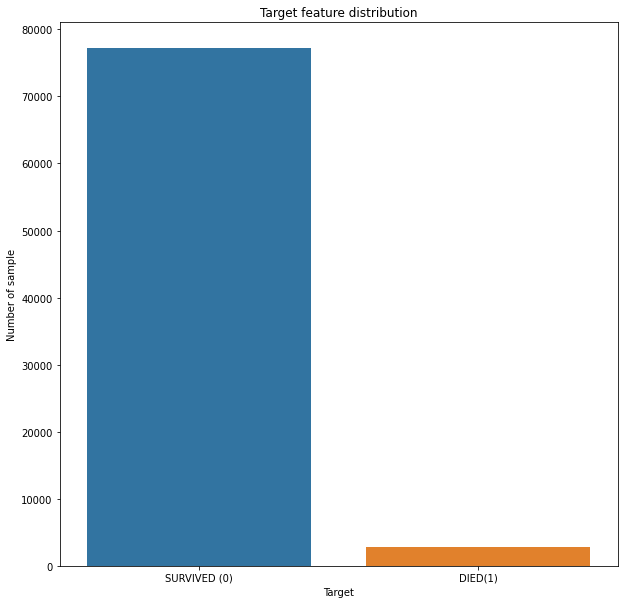

In [21]:
plt.figure(figsize=(10,10))
sns.barplot(["SURVIVED (0)","DIED(1)"], ys.value_counts())
plt.ylabel("Number of sample")
plt.xlabel("Target")
plt.title("Target feature distribution")
plt.show()


Bar charts of  categorical variables.
For 4 categorical variables , just uncomment increments

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


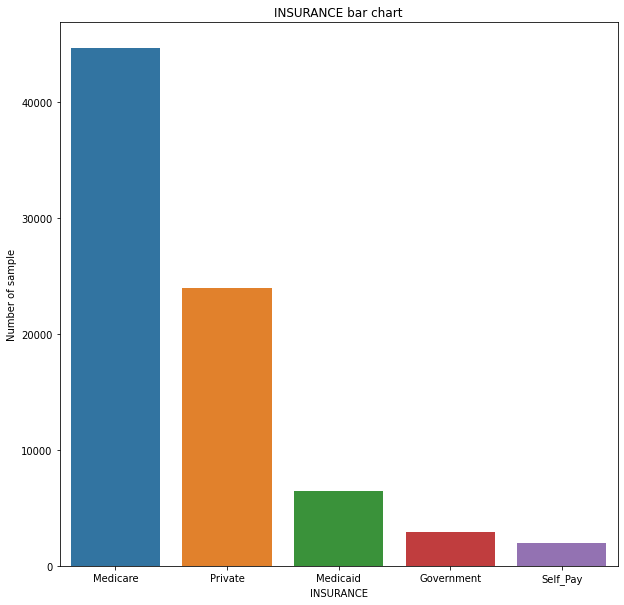

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


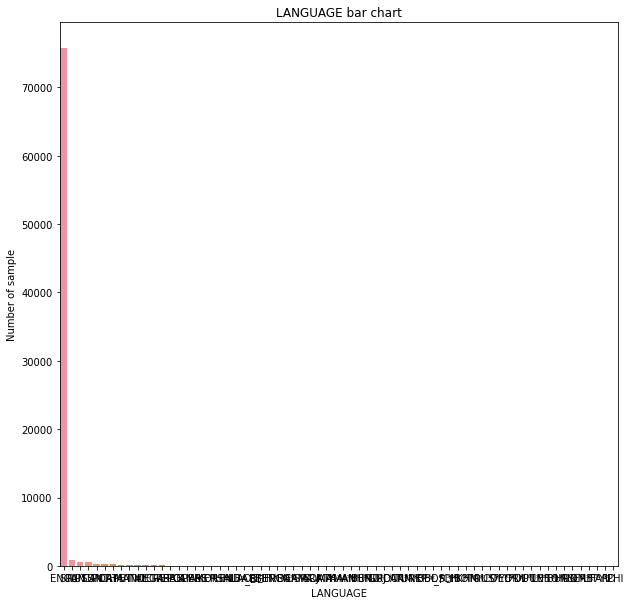

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


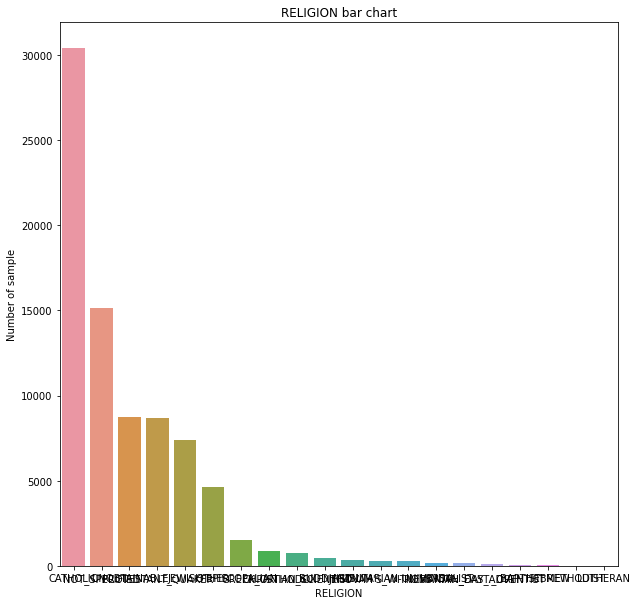

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


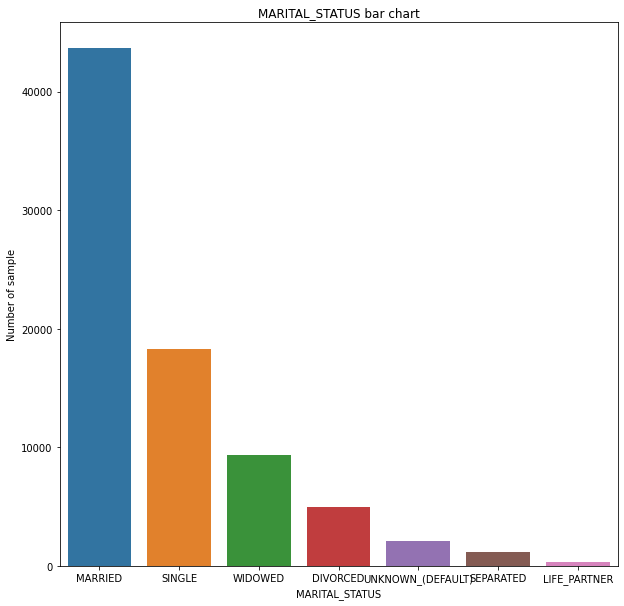

In [22]:
i=0
for colum in x_df.select_dtypes('object'):
    plt.figure(figsize=(10,10))
    sns.barplot(x_df[colum].value_counts().index, x_df[colum].value_counts().values)
    plt.ylabel("Number of sample")
    plt.xlabel(colum)
    plt.title(colum+" "+"bar chart")
    plt.show()
    i+=1
    if i==4:
      break
    

In [23]:
x_df.ETHNICITY.unique()

array(['WHITE', 'OTHER', 'UNKNOWN/NOT_SPECIFIED',
       'HISPANIC/LATINO_-_GUATEMALAN', 'BLACK/AFRICAN_AMERICAN',
       'BLACK/HAITIAN', 'BLACK/CAPE_VERDEAN', 'ASIAN',
       'HISPANIC/LATINO_-_COLOMBIAN', 'WHITE_-_BRAZILIAN',
       'ASIAN_-_KOREAN', 'UNABLE_TO_OBTAIN', 'HISPANIC_OR_LATINO',
       'ASIAN_-_CHINESE', 'AMERICAN_INDIAN/ALASKA_NATIVE',
       'PATIENT_DECLINED_TO_ANSWER', 'MIDDLE_EASTERN',
       'WHITE_-_OTHER_EUROPEAN', 'HISPANIC/LATINO_-_DOMINICAN',
       'BLACK/AFRICAN', 'HISPANIC/LATINO_-_SALVADORAN', 'WHITE_-_RUSSIAN',
       'ASIAN_-_VIETNAMESE', 'HISPANIC/LATINO_-_CENTRAL_AMERICAN_(OTHER)',
       'ASIAN_-_OTHER', 'PORTUGUESE',
       'NATIVE_HAWAIIAN_OR_OTHER_PACIFIC_ISLANDER',
       'ASIAN_-_ASIAN_INDIAN', 'WHITE_-_EASTERN_EUROPEAN',
       'HISPANIC/LATINO_-_PUERTO_RICAN', 'MULTI_RACE_ETHNICITY',
       'HISPANIC/LATINO_-_MEXICAN', 'ASIAN_-_JAPANESE',
       'HISPANIC/LATINO_-_CUBAN', 'ASIAN_-_FILIPINO', 'SOUTH_AMERICAN',
       'ASIAN_-_CAMBODIAN', 'CARIB

Correlation between a selection of features and the target feature ys

We can see that the 14 variables which impacted died or survival of people are : RESP_RATE_MEAN_DAY1, Adltrespfl, RESP_RATE_MAX_DAY1, RESP_RATE_MEAN_DAY2 ,RESP_RATE_MAX_DAY2, HR_MAX_DAY2, HR_MAX_DAY1, HR_MEAN_DAY2, TEMP_MAX_DAY2,HR_MIN_DAY1, HR_MEAN_DAY1, Coag/hemrdx, Acrenlfail, RESP_RATE_MIN_DAY1.

And the 14 worst correlated are : DIAS_BP_MIN_DAY2', 'MEAN_BP_MIN_DAY2', 'SYS_BP_MIN_DAY1','Hyperlipidem', 'DIAS_BP_MIN_DAY1', 'Coronathero','MEAN_BP_MIN_DAY1', 'Unclassified', 'DIAS_BP_MEAN_DAY2',
'SYS_BP_MIN_DAY2', 'SPO2_MEAN_DAY1', 'GLUCOSE_MIN_DAY2',
'DIAS_BP_MAX_DAY2', 'DiabMelnoc

In [24]:
#best correlated with ys
c_df=x_df.copy()
c_df['target']=ys.copy()
c_df_corr=c_df.corr()
best_correlation=c_df_corr['target'].sort_values(ascending=False)


In [25]:
#15 best correlated with ys
best_correlation[:15]

target                      1
RESP_RATE_MEAN_DAY1   0.09577
Adltrespfl            0.09083
RESP_RATE_MAX_DAY1    0.09065
RESP_RATE_MEAN_DAY2   0.08938
RESP_RATE_MAX_DAY2    0.08614
HR_MAX_DAY2           0.07349
HR_MAX_DAY1            0.0726
HR_MEAN_DAY2          0.06608
TEMP_MAX_DAY2         0.06509
HR_MIN_DAY1           0.06478
HR_MEAN_DAY1          0.06327
Coag/hemrdx           0.05532
Acrenlfail            0.04861
RESP_RATE_MIN_DAY1    0.04509
Name: target, dtype: float64

In [26]:
#worse correlated with ys
worst_correlation=c_df_corr['target'].sort_values(ascending=True)

#15 worse correlated with ys
worst_correlation[:14]

DIAS_BP_MIN_DAY2    -0.05402
MEAN_BP_MIN_DAY2    -0.05391
SYS_BP_MIN_DAY1     -0.04932
Hyperlipidem        -0.04607
DIAS_BP_MIN_DAY1     -0.0449
Coronathero         -0.04468
MEAN_BP_MIN_DAY1    -0.04118
Unclassified        -0.03702
DIAS_BP_MEAN_DAY2   -0.03479
SYS_BP_MIN_DAY2     -0.03226
SPO2_MEAN_DAY1      -0.02853
GLUCOSE_MIN_DAY2    -0.02631
DIAS_BP_MAX_DAY2    -0.02581
DiabMelnoc          -0.02501
Name: target, dtype: float64

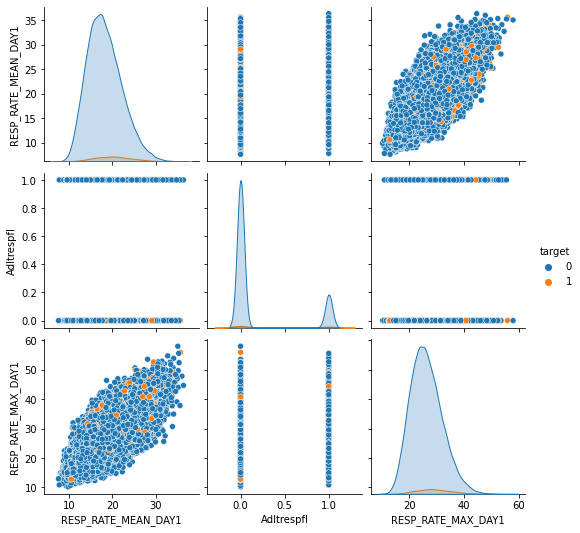

In [27]:
#pairplot of the 4 most correlated variables with ys
sns.pairplot(c_df[best_correlation[:4].index.tolist()],hue='target')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


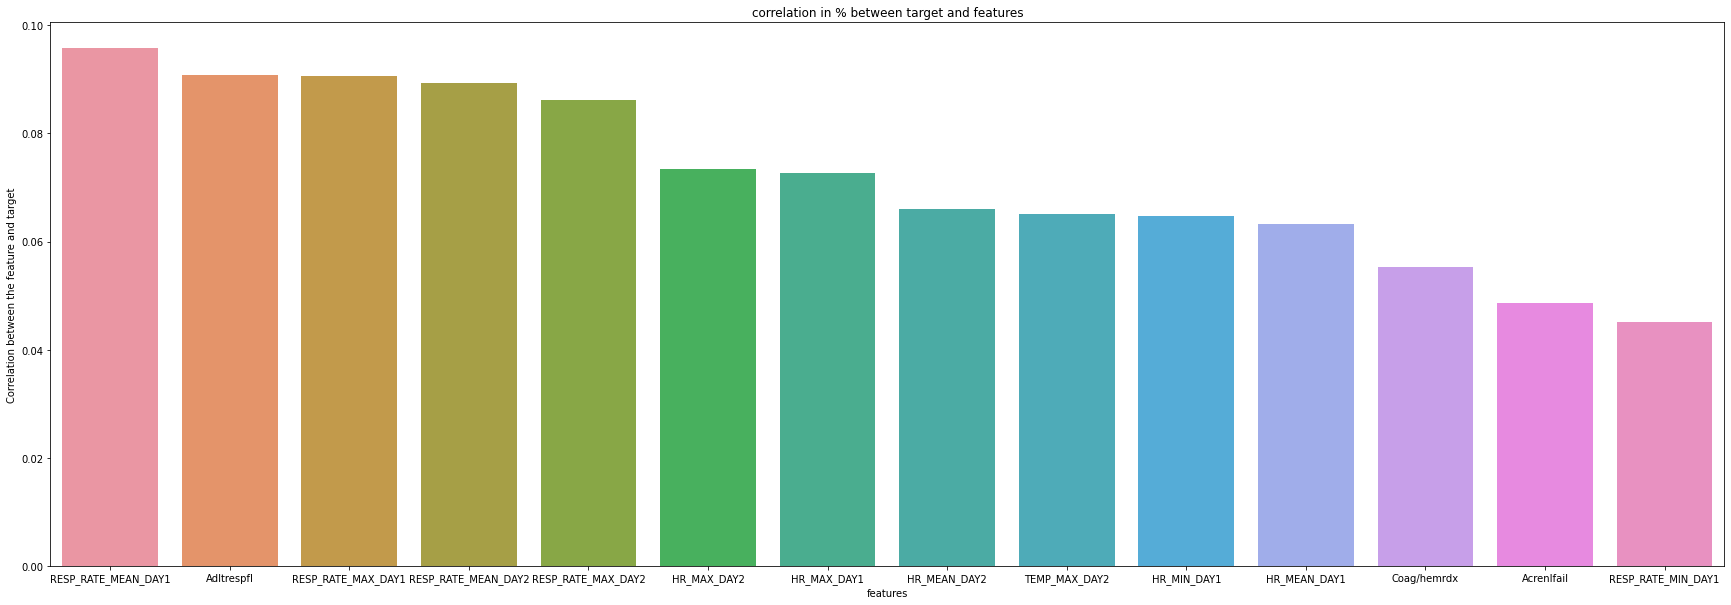

In [28]:
#barplot of the best 15 correlated features with ys
plt.figure(figsize=(30,10))
sns.barplot(best_correlation[:15].drop('target').index, best_correlation[:15].drop('target').values)
plt.ylabel("Correlation between the feature and target")
plt.xlabel("features")
plt.title("correlation in % between target and features")
plt.show()

Identify features that have outliers by analysis with Boxplot.

We can see from boxplot that features which have outliers are : ['HR_MIN_DAY1', 'HR_MAX_DAY1', 'HR_MEAN_DAY1', 'SYS_BP_MIN_DAY1',
       'SYS_BP_MAX_DAY1', 'SYS_BP_MEAN_DAY1', 'DIAS_BP_MIN_DAY1',
       'DIAS_BP_MAX_DAY1', 'DIAS_BP_MEAN_DAY1', 'MEAN_BP_MIN_DAY1',
       'MEAN_BP_MAX_DAY1', 'MEAN_BP_MEAN_DAY1', 'RESP_RATE_MIN_DAY1',
       'RESP_RATE_MAX_DAY1', 'RESP_RATE_MEAN_DAY1', 'TEMP_MIN_DAY1',
       'TEMP_MAX_DAY1', 'TEMP_MEAN_DAY1', 'SPO2_MIN_DAY1', 'SPO2_MAX_DAY1',
       'SPO2_MEAN_DAY1', 'GLUCOSE_MIN_DAY1', 'GLUCOSE_MAX_DAY1',
       'GLUCOSE_MEAN_DAY1', 'HR_MIN_DAY2', 'HR_MAX_DAY2', 'HR_MEAN_DAY2',
       'SYS_BP_MIN_DAY2', 'SYS_BP_MAX_DAY2', 'SYS_BP_MEAN_DAY2',
       'DIAS_BP_MIN_DAY2', 'DIAS_BP_MAX_DAY2', 'DIAS_BP_MEAN_DAY2',
       'MEAN_BP_MIN_DAY2', 'MEAN_BP_MAX_DAY2', 'MEAN_BP_MEAN_DAY2',
       'RESP_RATE_MIN_DAY2', 'RESP_RATE_MAX_DAY2', 'RESP_RATE_MEAN_DAY2',
       'TEMP_MIN_DAY2', 'TEMP_MAX_DAY2', 'TEMP_MEAN_DAY2', 'SPO2_MIN_DAY2',
       'SPO2_MAX_DAY2', 'SPO2_MEAN_DAY2', 'GLUCOSE_MIN_DAY2',
       'GLUCOSE_MAX_DAY2', 'GLUCOSE_MEAN_DAY2]


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


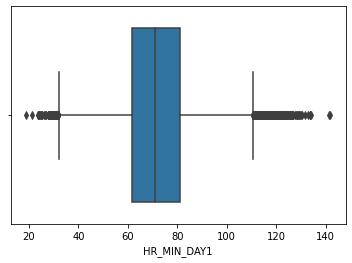

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


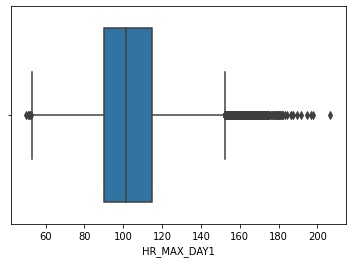

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


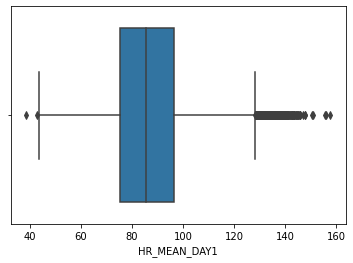

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


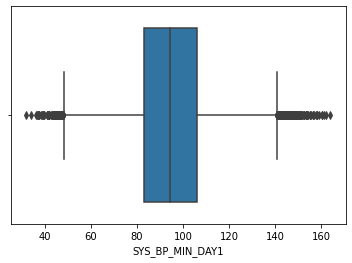

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


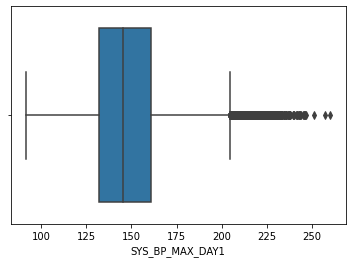

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


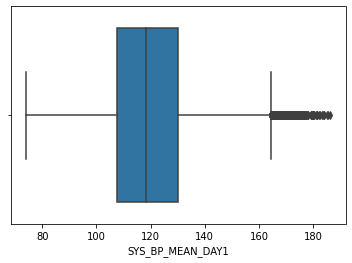

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


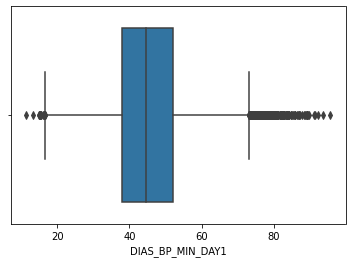

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


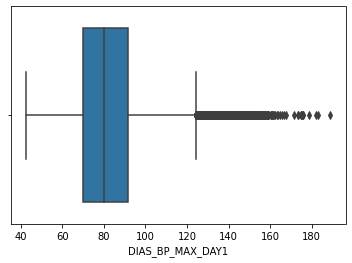

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


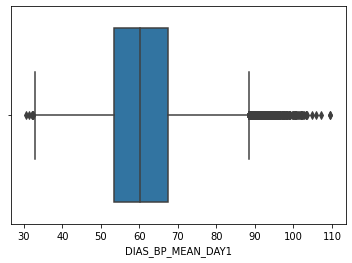

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


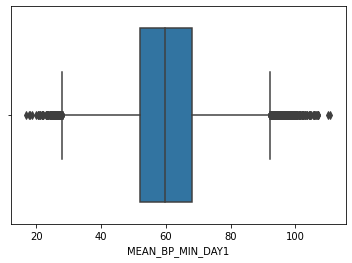

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


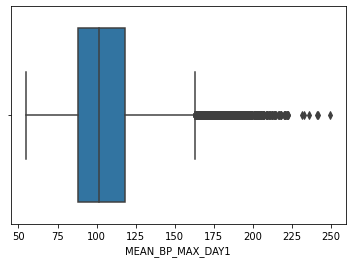

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


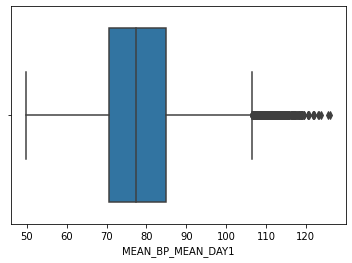

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


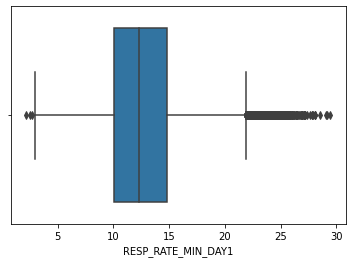

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


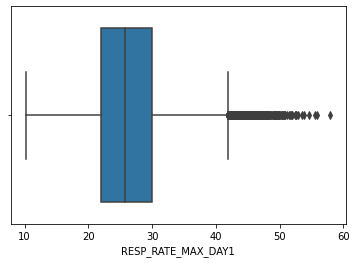

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


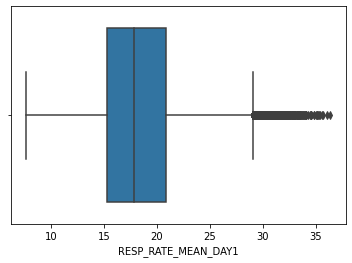

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


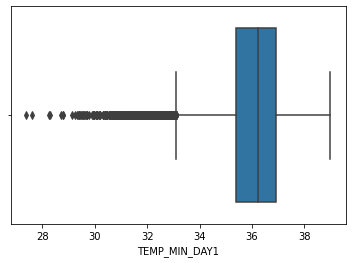

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


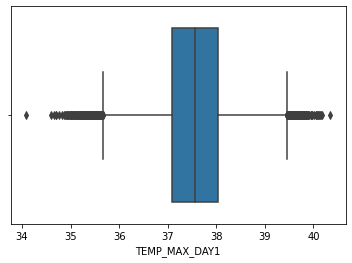

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


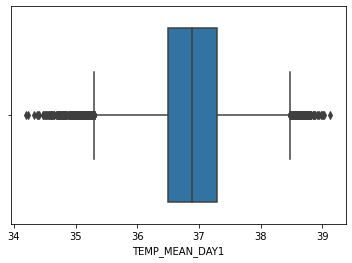

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


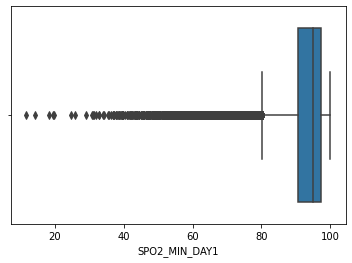

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


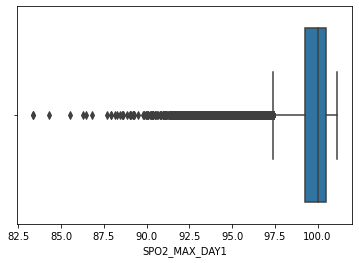

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


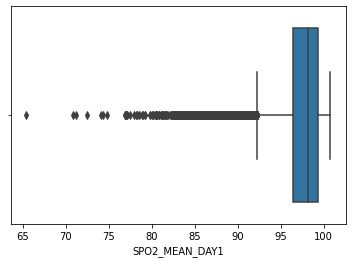

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


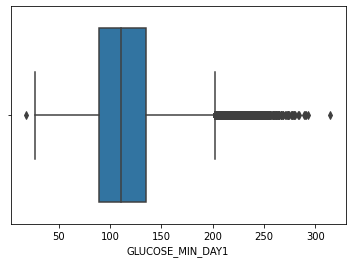

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


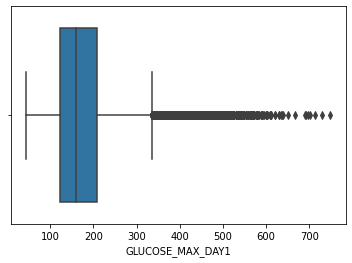

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


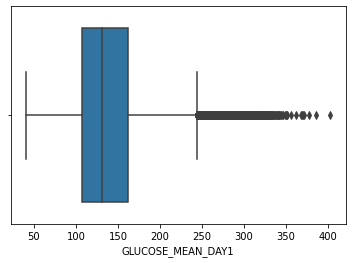

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


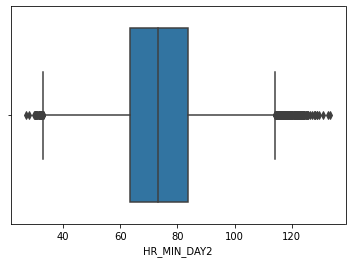

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


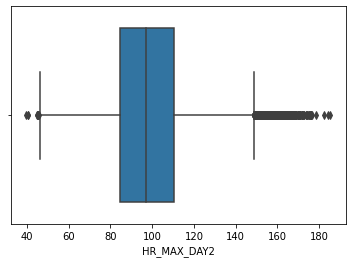

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


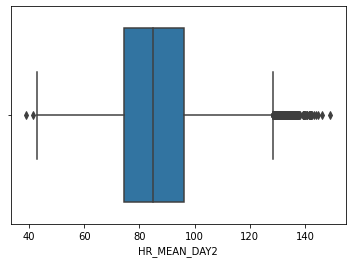

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


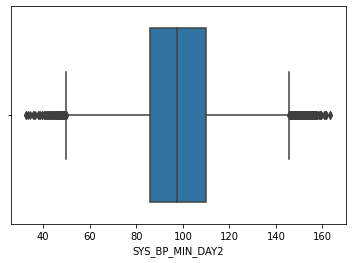

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


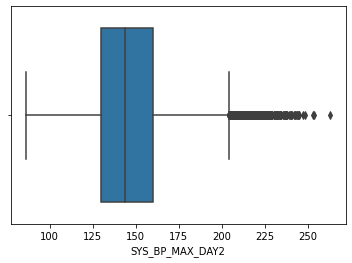

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


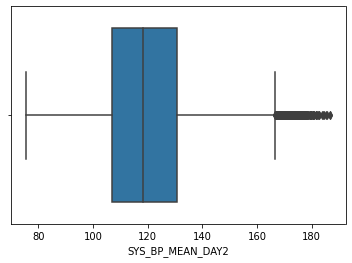

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


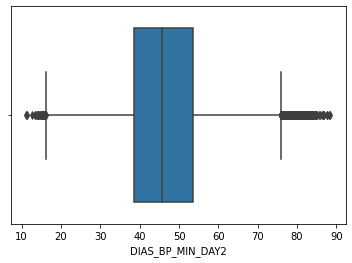

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


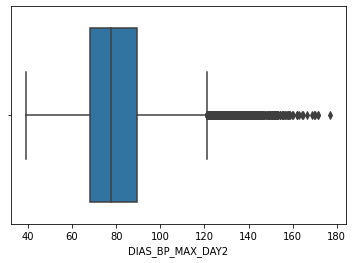

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


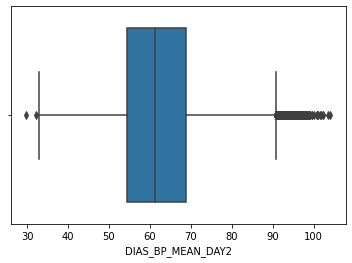

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


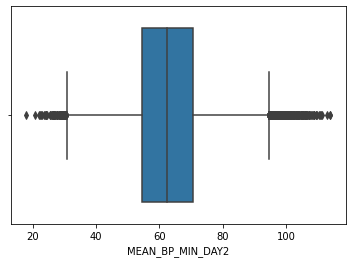

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


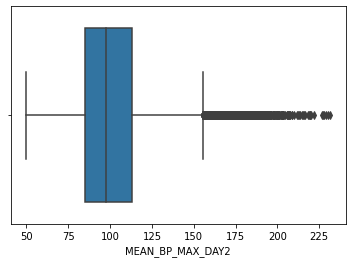

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


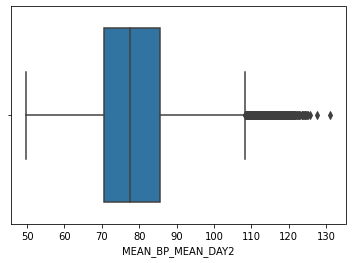

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


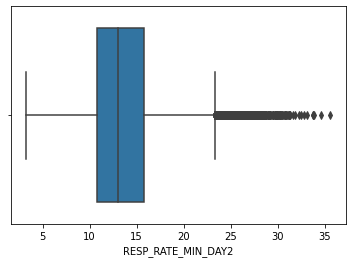

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


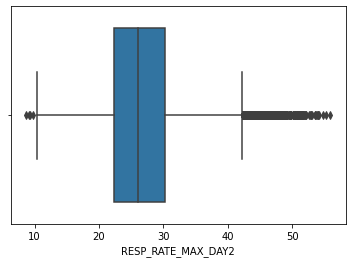

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


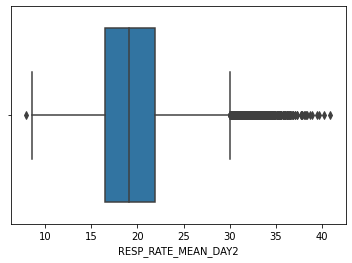

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


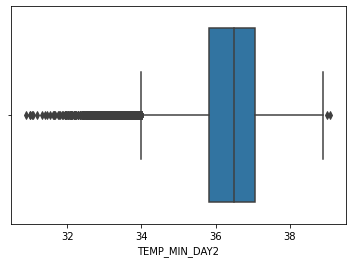

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


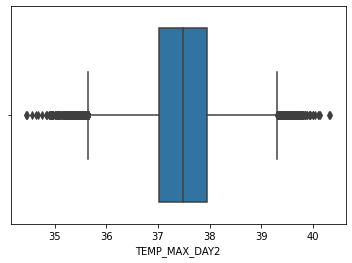

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


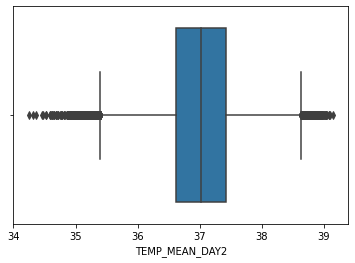

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


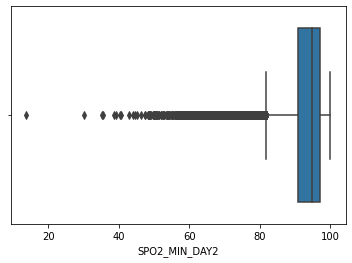

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


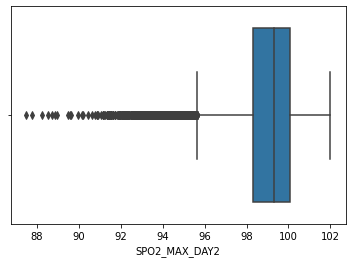

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


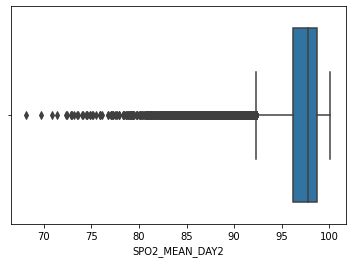

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


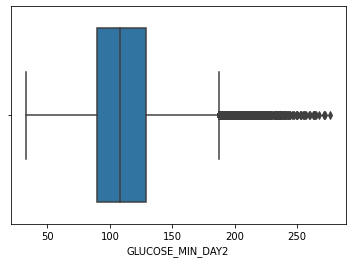

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


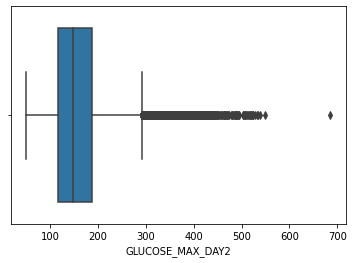

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


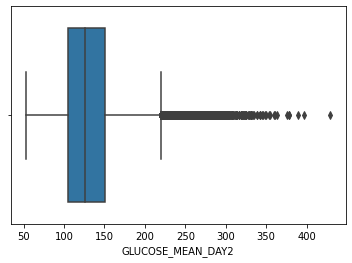

In [29]:
#uncomment the code above if your want to visualize the graph
#for colum in x_df.select_dtypes('float'):
#    sns.boxplot(x_df[colum])
#    plt.show()

features_with_outliers = ['HR_MIN_DAY1', 'HR_MAX_DAY1', 'HR_MEAN_DAY1', 
                          'SYS_BP_MIN_DAY1', 'SYS_BP_MAX_DAY1', 'SYS_BP_MEAN_DAY1',
                          'DIAS_BP_MIN_DAY1', 'DIAS_BP_MAX_DAY1', 'DIAS_BP_MEAN_DAY1',
                          'MEAN_BP_MIN_DAY1', 'MEAN_BP_MAX_DAY1', 'MEAN_BP_MEAN_DAY1',
                          'RESP_RATE_MIN_DAY1', 'RESP_RATE_MAX_DAY1', 'RESP_RATE_MEAN_DAY1',
                          'TEMP_MIN_DAY1', 'TEMP_MAX_DAY1', 'TEMP_MEAN_DAY1', 'SPO2_MIN_DAY1',
                          'SPO2_MAX_DAY1', 'SPO2_MEAN_DAY1', 'GLUCOSE_MIN_DAY1', 'GLUCOSE_MAX_DAY1',
                          'GLUCOSE_MEAN_DAY1', 'HR_MIN_DAY2', 'HR_MAX_DAY2', 'HR_MEAN_DAY2', 'SYS_BP_MIN_DAY2',
                          'SYS_BP_MAX_DAY2', 'SYS_BP_MEAN_DAY2', 'DIAS_BP_MIN_DAY2', 'DIAS_BP_MAX_DAY2',
                          'DIAS_BP_MEAN_DAY2', 'MEAN_BP_MIN_DAY2', 'MEAN_BP_MAX_DAY2', 'MEAN_BP_MEAN_DAY2',
                          'RESP_RATE_MIN_DAY2', 'RESP_RATE_MAX_DAY2', 'RESP_RATE_MEAN_DAY2', 'TEMP_MIN_DAY2',
                          'TEMP_MAX_DAY2', 'TEMP_MEAN_DAY2', 'SPO2_MIN_DAY2', 'SPO2_MAX_DAY2', 'SPO2_MEAN_DAY2',
                          'GLUCOSE_MIN_DAY2', 'GLUCOSE_MAX_DAY2', 'GLUCOSE_MEAN_DAY2']

for feature in features_with_outliers:
    sns.boxplot(x_df[feature])
    plt.show()                          


Some features have outliers, but they do not skew the data a lot (e.g. even glucose_max_day has values in the 500s and only one at 700)

Below we can see the differents values which are outliers. That is mean values out of interquantile intervale

In [30]:
#identify the outliers values per each feature
for colum in x_df.select_dtypes('float').drop(['ECodes:Adverseeffectsofmedicalcare', 'Otnutritdx', 'Othnervdx'], axis=1):
  print('--------',colum,'--------------')
  #Q1 computation
  q1=x_df[colum].quantile(q=0.25)
  #Q2
  q3=x_df[colum].quantile(q=0.75)
  #interquantile IQR
  IQR=q3-q1
  #lower bound
  lower_bound=q1-1.5*IQR
  #upper bound
  upper_bound=q3+1.5*IQR
  #retreive outliers values in pd form
  outlier_pd=x_df[(x_df[colum]>upper_bound)|(x_df[colum]<lower_bound ) ][colum]
  print(outlier_pd)
  

-------- HR_MIN_DAY1 --------------
2       118.2
78      120.2
197       118
323     111.9
343     112.1
         ... 
79326   114.3
79329   117.4
79615   114.2
79735   114.6
79821   115.1
Name: HR_MIN_DAY1, Length: 656, dtype: float64
-------- HR_MAX_DAY1 --------------
2       175.2
29      167.2
78      154.3
112       157
164     152.2
         ... 
79197   162.2
79658   175.1
79668   153.2
79748   152.2
79924     153
Name: HR_MAX_DAY1, Length: 754, dtype: float64
-------- HR_MEAN_DAY1 --------------
2       140.9
78      137.8
323       134
343     140.6
508     144.3
         ... 
78937   133.9
79024   133.6
79197   139.2
79230   128.9
79940   130.6
Name: HR_MEAN_DAY1, Length: 515, dtype: float64
-------- SYS_BP_MIN_DAY1 --------------
90       47.8
540     156.6
710     145.4
711     43.91
836     147.2
         ... 
79507   146.4
79561   143.4
79623   145.3
79739   45.59
79938   141.4
Name: SYS_BP_MIN_DAY1, Length: 432, dtype: float64
-------- SYS_BP_MAX_DAY1 --------------
53

## 4. Preprocessing

### Code: Missing values handling

The simplest solution is to eliminate all the columns where there is missing data, but a large part of the information may be lost.

If a small number of instances is concerned, it is more pertinent to delete the rows (instances) rather than the entire columns (variables). But you need to **pay attention**, if you **cannot** change the number of rows in the **test set**, or the competition grader will **fail**.

A third solution would be to replace undefined values with the most probable value of the variable. As these missing values relate exclusively to categorical and binary variables, the most probable value is the [*mode*](https://en.wikipedia.org/wiki/Mode_(statistics)).

A first baseline version is given, but it should be improved. It discards all categorical features and instances with NAN.

In [ ]:
"""
print(x_df.shape, x_test_df.shape)

x_baseline_df = x_df.select_dtypes([np.number]).copy()
x_baseline_test_df = x_test_df.select_dtypes([np.number]).copy()

x_baseline_df.fillna(0, inplace=True)
x_baseline_test_df.fillna(0, inplace=True)

print(x_baseline_df.shape, x_baseline_test_df.shape)
"""
print("This cell presents a baseline on data preprocessing, which we happily skipped over to implement our own solution")

This cell presents a baseline on data preprocessing, which we happily skipped over to implement our own solution


#### Exploration

First check the number of missing data per features and per instances (patient). Don't forget to process both the training and the test sets!

<span style="color:red">Implement your solution below</span>

In [31]:
print("A bit of analysis:")
print()
count_nulls_train = (x_df[x_df.columns[x_df.isna().any()]].isnull()).sum()
print("Columns with null values in train dataframe: ")
print(count_nulls_train)
print("_________________________")
count_nulls_test = (x_test_df[x_test_df.columns[x_test_df.isna().any()]].isnull()).sum()
print("Columns with null values in test dataframe: ")
print(count_nulls_test)
print("_________________________")
print(ys[x_df.isna().any(axis=1)])

A bit of analysis:

Columns with null values in train dataframe: 
LANGUAGE                              1
MARITAL_STATUS                        1
ICU                                   2
ECodes:Adverseeffectsofmedicalcare    6
Otnutritdx                            2
Othnervdx                             1
dtype: int64
_________________________
Columns with null values in test dataframe: 
LANGUAGE                              2
ECodes:Adverseeffectsofmedicalcare    3
dtype: int64
_________________________
2251     0
9983     0
10549    0
10831    0
17012    0
23088    0
32539    0
42762    0
53191    0
53390    0
56772    0
61852    0
71511    0
dtype: int64


Conclusion:

Since all the missing values belong to survivors, we do not have enough data to state whether the missing values suggest anything. Therefore, we will replace them with the most common values.

In [32]:
def find_mode(df_train):
  """
  Finds the modes for the missing values in df_train. Returns the modes for processing the train and test dataframes.
  Param:
    df_train: dataframe to extract modes from
  Returns:
    modes: the most common values in columns with missing values
    columns_with_null: the columns with missing values
  """
  columns_with_null = (df_train[df_train.columns[df_train.isna().any()]].isnull()).sum().index
  modes = []
  for column in columns_with_null:
    modes.append((df_train[column].mode()[0]))

  return modes, columns_with_null

def replace_nan_mode(df, modes, columns_with_null):
  """
    Replaces all missing values with modes (expected: most common value).
    Params:
      df: dataframe
      modes: the values to replace missing values in the columns with missing values
      columns_with_null: columns where to fill missing values
    returns:
      moded_df: dataframe where missing values are replaced with the mode
  """
  #copy df to void changes in the original one
  mode_df = df.copy()

  for column,mode in zip(columns_with_null, modes):
    mode_df[column] = df[column].fillna(mode)
  
  return mode_df

#### Fixing

Now you can apply your chosen strategy

In [33]:
modes, columns = find_mode(x_df)

train_x_df_processed, test_x_df_processed = replace_nan_mode(x_df, modes, columns), replace_nan_mode(x_test_df, modes, columns)


### Reduce data scarcity (not enough data per class)

For example, you could simplify data by grouping rare categories.

In [34]:
def replace_language_others(df):
  """
    Replaces non-english languages in column "LANGUAGE" to "OTHR" (other).
    param:
      df: dataframe with column "LANGUAGE"
    returns:
      new_df: dataframe where non-english rows are replaced to "OTHR"
  """
  col = "LANGUAGE"
  new_df = df.copy()
  new_df[col][df[col]!="ENGL"] = "OTHR"
  return new_df

def replace_ethnicities(df, groups):
  """
    Groups major ethnic groups with each other. Warning: If a group is not found, it won't be processed.
    Params:
      df: dataframe with column "ETHNICITY"
      groups: list of strings which will be searched in the "ETHNICITY" column to be replaced, if found
    Returns:
      new_df: processed df
  """
  col = "ETHNICITY"
  new_df = df.copy()
  for ethnic_group in groups:
    new_df[col][df[col].str.contains(ethnic_group)] = ethnic_group
  return new_df

def replace_religions(df, religions):
  """
    Groups minor religions under "OTHER".
    Params:
      df: dataframe with column "RELIGION"
      religions: list of strings which if not found in the "RELIGION" column, will be replaced with "OTHER"
    Returns:
      new_df: processed df
  """
  new_df = df.copy()
  #if the elements of religions are not found in the value of the "RELIGION" column, replace it with "OTHER"
  new_df["RELIGION"][~df["RELIGION"].str.contains("|".join(religions))] = "OTHER"
  return new_df

In [35]:
categorical_columns = [col for col in x_df.columns if x_df[col].dtype=="O"]
print(categorical_columns)
"""
for col in categorical_columns:
  print(x_df[col].nunique())
  occurences = x_df.groupby(col).size()
  print(occurences)
"""
#Uncomment the block above to view categorical columns and the occurences of each values in each column.
print()

['INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'GENDER', 'ICU']



Following some analysis, we decide to group ethnic subgroups in the generalized groups.

For religions, we group the non-majority religions into "OTHER".

For languages, we group into English and Non-english categories.

In [36]:
train_x_df_processed, test_x_df_processed = replace_language_others(train_x_df_processed), replace_language_others(test_x_df_processed)

ethnic_groups = ["AMERICAN_INDIAN", "ASIAN", "BLACK", "CARRIBEAN_ISLAND", "HISPANIC", "MIDDLE_EASTERN", 
          "MULTI_RACE", "NATIVE_HAWAIIAN_OR_OTHER_PACIFIC_ISLANDER", "OTHER", "PATIENT_DECLINED_TO_ANSWER", "PORTUGUESE", "SOUTH_AMERICAN",
          "UNABLE_TO_OBTAIN", "UNKNOWN/NOT_SPECIFIED", "WHITE"]

train_x_df_processed, test_x_df_processed = replace_ethnicities(train_x_df_processed, ethnic_groups), replace_ethnicities(test_x_df_processed, ethnic_groups)

religion_groups = ["CATHOLIC", "NOT_SPECIFIED", "UNOBTAINABLE", "PROTESTANT_QUAKER", "JEWISH", "OTHER", "EPISCOPALIAN"]
train_x_df_processed, test_x_df_processed = replace_religions(train_x_df_processed, religion_groups), replace_religions(test_x_df_processed, religion_groups)

<ipython-input-34-1f0598cde11d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[col][df[col]!="ENGL"] = "OTHR"
<ipython-input-34-1f0598cde11d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[col][df[col].str.contains(ethnic_group)] = ethnic_group
<ipython-input-34-1f0598cde11d>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["RELIGION"][~df["RELIGION"].str.contains("|".join(religions))] = "OTHER"


### Transforming categorical data into integers using two types of encoding

Categorical variables are presented in the form of character strings. Most models will not be able to handle them in such a format.

#### Simple digital encoding

Two of the simplest methods are `LabelEncoder` from Scikit-Learn and` factorize` from pandas. They simply consist of replacing each new category encountered with an integer, starting with 0. This is perhaps not the most efficient method, since it presupposes proximity between the categories coded with close values.

#### 1-Hot encoding

Another type of encoding is often more efficient, in particular, it has the advantage of not ordering the classes in a particular way (not necessarily in line with the proximity of these classes to each other).

A pandas method allows this to be done in 1 line of code with the `get_dummies` function.

Exemple d'encodage 1-hot avec la fonction `get_dummies` de pandas (pour MARITAL_STATUS) :

|    |   DIVORCED |   LIFE_PARTNER |   MARRIED |   SEPARATED |   SINGLE |   UNKNOWN_(DEFAULT) |   WIDOWED |
|---:|-----------:|---------------:|----------:|------------:|---------:|--------------------:|----------:|
|  0 |          1 |              0 |         0 |           0 |        0 |                   0 |         0 |
|  1 |          0 |              0 |         0 |           0 |        1 |                   0 |         0 |
|  2 |          0 |              0 |         0 |           0 |        0 |                   0 |         1 |
|  3 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |
|  4 |          0 |              0 |         1 |           0 |        0 |                   0 |         0 |

You can choose your preferred way of encoding the categorical data.

In [37]:
def one_hot_encoding(df, features):
  """
    Given a dataframe and categorical columns/features, returns a transformed dataframe where the columns are one-hot-encoded.
    Params:
      df: dataframe to be processed
      features: the features to be one-hot-encoded
    Returns:
      changed_df: dataframe with features encoded
  """
  changed_df = pd.get_dummies(df, columns=features)

  return changed_df

In [38]:
#one hot encoding the categorical columns
train_x_df_processed, test_x_df_processed = one_hot_encoding(train_x_df_processed, categorical_columns), one_hot_encoding(test_x_df_processed, categorical_columns)

In [39]:
print(train_x_df_processed.columns)

Index(['AGE', 'HR_MIN_DAY1', 'HR_MAX_DAY1', 'HR_MEAN_DAY1', 'SYS_BP_MIN_DAY1',
       'SYS_BP_MAX_DAY1', 'SYS_BP_MEAN_DAY1', 'DIAS_BP_MIN_DAY1',
       'DIAS_BP_MAX_DAY1', 'DIAS_BP_MEAN_DAY1',
       ...
       'ETHNICITY_UNABLE_TO_OBTAIN', 'ETHNICITY_UNKNOWN/NOT_SPECIFIED',
       'ETHNICITY_WHITE', 'GENDER_F', 'GENDER_M', 'ICU_CCU', 'ICU_CSRU',
       'ICU_MICU', 'ICU_SICU', 'ICU_TSICU'],
      dtype='object', length=372)


We now have quite a lot of columns in our data.

In [40]:
train_x_df_processed.columns[train_x_df_processed.columns.str.contains("LANGUAGE")]

Index(['LANGUAGE_ENGL', 'LANGUAGE_OTHR'], dtype='object')

In [41]:
print((train_x_df_processed["LANGUAGE_ENGL"]).sum())
print((train_x_df_processed["LANGUAGE_OTHR"]).sum())

75734
4265


#### Removing single-valued variables (constants)

In [42]:
def find_constant_columns(df):
  """
  Finds columns with constant values in dataframe df.
  Param:
    df: dataframe
  Returns:
    constant_columns: a list of column names where the values are constant.
  """
  constant_columns = []
  for column in train_x_df_processed.columns:
    if train_x_df_processed[column].nunique()==1:
      constant_columns.append(column)
  return constant_columns

In [43]:
constant_columns = find_constant_columns(train_x_df_processed)
#remove constant columns from train and test dataset
train_x_df_processed = train_x_df_processed.drop(constant_columns, axis=1)
test_x_df_processed = test_x_df_processed.drop(constant_columns, axis=1)

In [44]:
print("A sample of columns with constant values:")
print(constant_columns[:20])

A sample of columns with constant values:
['Tuberculosis', 'Immuniz/scrn', 'Chestpain', 'Othheartdx', 'Hd/nckcancr', 'OtherCVD', 'TIA', 'Artembolism', 'Varicosevn', 'Esophcancer', 'Hemmorhoids', 'Othveindx', 'Influenza', 'Tonsillitis', 'Bronchitis', 'Otuprspin', 'Stomchcancr', 'Lungexternl', 'Teethdx', 'Mouthdx']


### Size reduction via PCA

### Creation of the validation set

Splitting train set into train and validation.



In [45]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    train_x_df_processed, ys, test_size=0.3
)

x_test = test_x_df_processed.copy()

Test the PCA to reduce the number of dimensions and see if this improves the result.

Before applying the PCA, it is advisable to standardize the data.

Standardizing data using min-max normalization.

In [46]:
#getting the min_max values for each column on the train data (so that it can be applied to valid and test)
min_maxes = []
for column in x_train.columns:
  min_maxes.append((x_train[column].min(),x_train[column].max()))
  #applying min_max normalization for every column on every dataset
for column, min_max in zip(x_train.columns, min_maxes):
  this_range =  min_max[1] - min_max[0]
  if this_range == 0:
    this_range = 1
  x_train[column] = (x_train[column] - min_max[0])/this_range
  x_valid[column] = (x_valid[column] - min_max[0])/this_range
  x_test[column] = (x_test[column] - min_max[0])/this_range

Print a graph that represents the first 2 dimensions of PCA and comment briefly.

In [49]:
pca = PCA(n_components=2)
pca.fit(x_train)
pca_x_train = pca.transform(x_train)

In [50]:
def plot_training_points(xs, ys, colors, features):
    for color, i, tgt_name in zip(colors, [0, 1], ['alive', 'dead']):
        plt.scatter(
            xs[ys == i, 0],
            xs[ys == i, 1],
            color=color,
            alpha=0.8,
            label=tgt_name,
            edgecolor="black",
        )
    plt.legend(loc="best", shadow=False, scatterpoints=1)
    plt.title("2-Class classification")
    plt.xlabel(features[0])
    plt.ylabel(features[1])


COLORS = ["red", "green"]

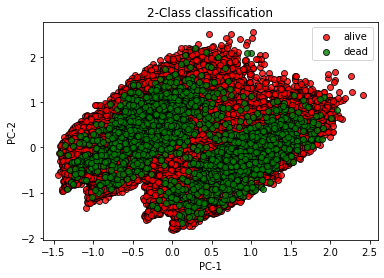

In [51]:
plot_training_points(pca_x_train[:,0:2], y_train, COLORS, ["PC-1", "PC-2"])

After observing various PCA column pairs, we notice there is no clear division between the target classes.

## 5. Classification models

Train the model

### Baseline

`LogisticRegression` or `RandomForestClassifier`

In [52]:
# Training using Random forest classifer 

model = ensemble.RandomForestClassifier(n_estimators=150, max_depth=5)

model.fit(x_train, y_train)  # training

RandomForestClassifier(max_depth=5, n_estimators=150)

In [53]:
# Training using gaussian NB Model
gaussian_nb_model = naive_bayes.GaussianNB()
gaussian_nb_model.fit(x_train, y_train)   #training

GaussianNB()

In [54]:
# Training using logistic regression Model
lr_model = linear_model.LogisticRegression()
lr_model.fit(x_train, y_train) #training

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

## 6. Evaluations

In [55]:
# Gaussian NB Model
y_pred = gaussian_nb_model.predict(x_valid)  # predictions

score = metrics.balanced_accuracy_score(y_valid, y_pred)  # scoring

print(f"Balanced accuracy score: {score:.3g}")

Balanced accuracy score: 0.499


In [56]:
# Logistic regression Model
y_pred = lr_model.predict(x_valid)  # predictions

score = metrics.balanced_accuracy_score(y_valid, y_pred)  # scoring

print(f"Balanced accuracy score: {score:.3g}")

Balanced accuracy score: 0.519


In [57]:
# Random forest classifer Model
y_pred = model.predict(x_valid)  # predictions

score = metrics.balanced_accuracy_score(y_valid, y_pred)  # scoring

print(f"Balanced accuracy score: {score:.3g}")

Balanced accuracy score: 0.5


### Code: Cross-validation

Use cross-validation (to get a more reliable estimate) combined with an exploration of hyperparameters (to improve results).

You can change the value of the cross-validation number (CV) depending on the error value and the time to train the models (compromise).

In [58]:
CV = 3
SCORING = "balanced_accuracy"

In [59]:
pca = decomposition.PCA()
pca__n_components = [130, 150, 170, 190]

Gaussian Model

In [60]:
# Define params to add to the grid search
gaussian_nb_param_grid = {"pca__n_components": pca__n_components}

In [61]:
# Initialisation of the model and the pipeline
gaussian_nb_model = naive_bayes.GaussianNB()
gaussian_nb_pipe = pipeline.Pipeline(
    steps=[("pca", pca), ("model", gaussian_nb_model)])

In [62]:
# Define the gridsearch using the pipeline and fit the model
gaussian_nb_search = model_selection.GridSearchCV(
    gaussian_nb_pipe,
    param_grid=gaussian_nb_param_grid,
    n_jobs=-1,
    scoring=SCORING,
    verbose=1,
    cv=CV,
)
gaussian_nb_search.fit(x_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('model', GaussianNB())]),
             n_jobs=-1, param_grid={'pca__n_components': [130, 150, 170, 190]},
             scoring='balanced_accuracy', verbose=1)

In [63]:
# Display the best CV Score
print(f"Best parameter (CV score: {gaussian_nb_search.best_score_:.3f})")

# Display the best parameters for the model
gaussian_nb_cv_best_params = pd.DataFrame(gaussian_nb_search.best_params_, index= ["values"])
with pd.option_context("display.float_format", "{:.2g}".format):
    display(gaussian_nb_cv_best_params)

# Show the the mean score and the standard deviation for each combination of hyperparameters
g_nb_cv_results = pd.DataFrame(gaussian_nb_search.cv_results_)

with pd.option_context("display.float_format", "{:.2g}".format):
    display(g_nb_cv_results[["param_pca__n_components", "mean_test_score", "std_test_score"]])

Best parameter (CV score: 0.620)


,pca__n_components
values,170


,param_pca__n_components,mean_test_score,std_test_score
0,130,0.55,0.0027
1,150,0.56,0.0071
2,170,0.62,0.046
3,190,0.5,0.0019


In [64]:
gaussian_nb_predict = gaussian_nb_search.predict(x_valid)

Logistic Regression

In [65]:
# Define params to add to the grid search
logistic_regression_param_grid = {
    "pca__n_components": pca__n_components,
    "model__penalty": ["none", "l2"]
} #l2 ridge

In [66]:
# Initialisation of the model and the pipeline
logistic_regression_model = linear_model.LogisticRegression()
logistic_regression_pipe = pipeline.Pipeline(
    steps=[('pca', pca), ('model', logistic_regression_model)])

In [67]:
# Define the gridsearch using the pipeline and fit the model
logistic_regression_search = model_selection.GridSearchCV(
    logistic_regression_pipe,
    param_grid=logistic_regression_param_grid,
    n_jobs=-1,
    scoring=SCORING,
    cv=CV,
    verbose=1,
)
logistic_regression_search.fit(x_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model__penalty': ['none', 'l2'],
                         'pca__n_components': [130, 150, 170, 190]},
             scoring='balanced_accuracy', verbose=1)

In [68]:
# Display the best CV score
print(f"Best parameter (CV score: {logistic_regression_search.best_score_:.3f})")

# Display the best parameters for the model
lr_cv_best_params = pd.DataFrame(logistic_regression_search.best_params_, index= ['values'])
with pd.option_context("display.float_format", "{:.2g}".format):
    display(lr_cv_best_params)

# Show the the mean score and the standard deviation for each combination of hyperparameters
lr_cv_results = pd.DataFrame(logistic_regression_search.cv_results_)

with pd.option_context("display.float_format", "{:.2g}".format):
    display(lr_cv_results[["param_pca__n_components", "param_model__penalty", "mean_test_score", "std_test_score"]])

Best parameter (CV score: 0.531)


,model__penalty,pca__n_components
values,none,190


,param_pca__n_components,param_model__penalty,mean_test_score,std_test_score
0,130,none,0.52,0.0054
1,150,none,0.53,0.0037
2,170,none,0.53,0.0047
3,190,none,0.53,0.005
4,130,l2,0.52,0.003
5,150,l2,0.52,0.004
6,170,l2,0.52,0.004
7,190,l2,0.52,0.004


In [69]:
lr_predict = logistic_regression_search.predict(x_valid)

Random Forest Classifier

In [70]:
# Define params to add to the random search
random_forest_param_distributions = {
    "pca__n_components": pca__n_components,
    'model__n_estimators': [200, 300, 400,500],
    'model__max_depth': [4, 5, 6, 7, 8],
    'model__max_features': ['auto', 'sqrt', 'log2'],
}

In [71]:
# Initialisation of the model and the pipeline
random_forest_model = ensemble.RandomForestClassifier()
random_forest_pipe = pipeline.Pipeline(
    steps=[("pca", pca), ("model", random_forest_model)])


In [72]:
# Define the randomsearch using the pipeline and fit the model
random_forest_search = model_selection.RandomizedSearchCV(
    random_forest_pipe,
    random_forest_param_distributions,
    n_iter= 5,
    n_jobs=-1,
    scoring=SCORING,
    verbose=1,
    cv=CV
)

random_forest_search.fit(x_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA()),
                                             ('model',
                                              RandomForestClassifier())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'model__max_depth': [4, 5, 6, 7, 8],
                                        'model__max_features': ['auto', 'sqrt',
                                                                'log2'],
                                        'model__n_estimators': [200, 300, 400,
                                                                500],
                                        'pca__n_components': [130, 150, 170,
                                                              190]},
                   scoring='balanced_accuracy', verbose=1)

In [73]:
# Display the best CV score
print(f"Best parameter (CV score: {random_forest_search.best_score_:.3f})")

# Display the best parameters for the model
lr_cv_best_params = pd.DataFrame(random_forest_search.best_params_, index= ['values'])
with pd.option_context("display.float_format", "{:.2g}".format):
    display(lr_cv_best_params)

# Show the the mean score and the standard deviation for each combination of hyperparameters
lr_cv_results = pd.DataFrame(random_forest_search.cv_results_)

with pd.option_context("display.float_format", "{:.2g}".format):
    display(lr_cv_results[["param_pca__n_components", "param_model__n_estimators", "param_model__max_features", "param_model__max_depth", "mean_test_score", "std_test_score"]])

Best parameter (CV score: 0.500)


,pca__n_components,model__n_estimators,model__max_features,model__max_depth
values,190,200,log2,7


,param_pca__n_components,param_model__n_estimators,param_model__max_features,param_model__max_depth,mean_test_score,std_test_score
0,190,200,log2,7,0.5,0
1,130,300,sqrt,5,0.5,0
2,170,400,sqrt,7,0.5,0
3,170,500,log2,7,0.5,0
4,130,500,sqrt,4,0.5,0


* **For 2 of the models** (at least 1 other than the proposed baseline):

    * For different values of one of the hyperparameters, give the average `balanced_accuracy` of the cross-validation in the form of Boxplots (or bar graph with an error bar): see the example presented in the graph below.
    
    * Briefly explain what observations to draw concerning the stability of the predictions.

![](img/boxplot-cv.png)

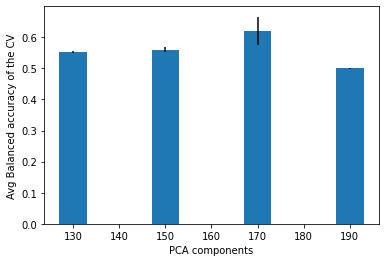

In [74]:
# Gaussian NB Model
# Plot a bar plot showing the different prediction scores
# for each value of the PCA n_components
param = gaussian_nb_search.cv_results_["param_pca__n_components"]
plt.bar(
    gaussian_nb_search.cv_results_["param_pca__n_components"],
    gaussian_nb_search.cv_results_["mean_test_score"],
    yerr=gaussian_nb_search.cv_results_["std_test_score"],
    width=6
)
plt.xlabel("PCA components")
plt.ylabel("Avg Balanced accuracy of the CV")
plt.show()

The height of the error bar and standard deviation is very small for almost all the pca n_components values which will lead to a more stable prediction.

But the best performing model is with 170 n_components for PCA which is less stable than the others. GaussianNB is still better performing than Logistic Regression and RandomForest, so we keep this model.

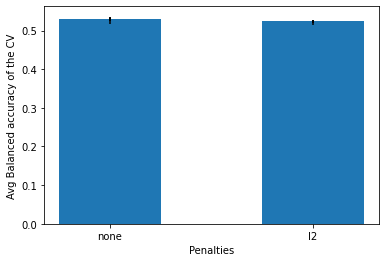

In [75]:
# Logistic regression Model
# Plot a bar plot showing the different prediction scores
# for each value of the Model penalty
param = logistic_regression_search.cv_results_["param_model__penalty"]

plt.bar(
    logistic_regression_search.cv_results_["param_model__penalty"],
    logistic_regression_search.cv_results_["mean_test_score"],
    yerr=logistic_regression_search.cv_results_["std_test_score"],
    width=0.5
)
plt.xlabel("Penalties")
plt.ylabel("Avg Balanced accuracy of the CV")
plt.show()

The height of the error bar and standard deviation is very small for almost all the penalties values which will lead to a more stable and consistent prediction.



---



* **For each of these 2 models, from the validation data created previously** (`x_valid`,` y_valid`):

    * Measure the area under the ROC curve (AUC) using the Scikit-Learn (`roc_auc_score`) function and compare the models with their respective combination of hyperparameters giving the best result.

In [76]:
# Area under the ROC curve for Guaussian NB
score  = metrics.roc_auc_score(y_valid, gaussian_nb_predict)
print(f"Score = {score:.3f}")

Score = 0.667


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


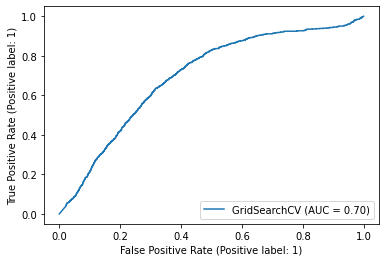

In [77]:
metrics.plot_roc_curve(gaussian_nb_search, x_valid, y_valid)

In [78]:
# Area under the ROC curve for the linear regression Model
score  = metrics.roc_auc_score(y_valid, lr_predict)
print(f"Score = {score:.3f}")

Score = 0.523


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


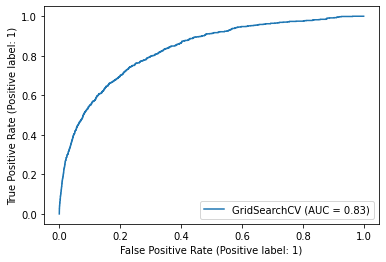

In [79]:
metrics.plot_roc_curve(logistic_regression_search, x_valid, y_valid)

We can deduce that the logistic regression is more precise than the GaussianNB model. However, we have an unbalanced dataset, and we consider balanced accuracy to be a more important metric.

* **For the model and its combination of hyperparameters offering the best result**:

    * Present the confusion matrix and describe it succinctly.

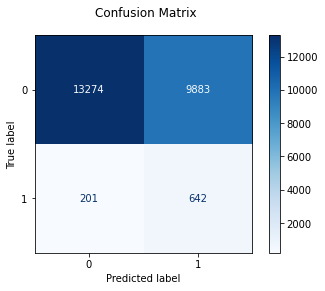

In [81]:
disp = metrics.ConfusionMatrixDisplay.from_estimator(
    gaussian_nb_search, x_valid, y_valid, cmap=plt.cm.Blues
)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

A confusion matrix is a summary of prediction results on a classification problem.
- 632 represents the number of patients who have been properly classified to be died during their stay in the hospital.
- 13274 represents the number of correctly classified patients who survive during their stay in the hospital.
- 9883 represents the number of patients misclassified as died but actually they are alive.
- 201 represents the number of patients misclassfied as alive but actually they are dead.  

### Explanation of what you have achieved, conclusion and perspectives

Explain the path that led you there

* What you tried:
    * What worked
    * What didn't work and how you fixed it
* What method did you use to choose the hyperparameters?
* Compare the training time of the main models you used?

What would you have done if you had had more time?

The final best score after everything we have done, is 0.69, using undersampling methods.

For the choice of hyperparameters we use Grid Search and we proceeded by elimination to find the best params to pass to the grid search. For example, for the choice of the PCA number of components we started with a small value considering the size of the dataset which is 50 and in order to decrease the processing time we give only 4 possible values of the PCA number of components with a difference of 20 between 2 consecutive values of the list. After training, if the value of the PCA number of components chosen is the last value in the list, we take this value and compare it with 3 other values larger than this one, all this comparing the CV score each time.

The reverse procedure is used for a smaller value in the list.

The computation time of a grid search using the Ramdon Forest classifier was very long and therefore required a powerful machine to run fast, which we do not have, so instead of the grid search we used a random forest search and limited the number of iterations to 5.

Between the 3 models tested, the Gaussian NB model is the one that perform well and has less computing time.

Afterwards, we explored the idea of oversampling the minority class with SMOTE. At first the oversampling reduced the performance of the model to 50%.

The first mistake we noticed was that we oversampled the validation dataset aswell, so we implemented a kfold training method to oversample only on the train set. However, even then the model did not improve its performance. We did not notice our second mistake.

We considered the idea that the model has too much data to learn from, and that we should instead try undersampling the majority class.

This ended up improving the performance of the model, so next we explored trying to work again with lower levels of n_components and undersampled data, and this resulted in the final high score of our team.

As a perspective we could try other models for this problem like deep learning ones. And also, we can try to do feature selection such as Recursive Feature Elimination (RFE) through these different methods to see if it can improve the score or not. 

## 7. Save the model predictions

* Use the following code to make predictions and to save them as a ZIP file
* Submit this ZIP file to [the challenge site](https://codalab.lisn.upsaclay.fr/competitions/328#participate-submit_results)
(`Participate > Submit/View Results > Submit`)
* The number of submissions is **limited** to **3 per day** and **30 in total!**
* Try your best to be the ***first on the leaderboard!***

<span style="color:red">
    !! Do not forget to modify the command of the prediction according to the data and models chosen !!
</span>

E.g.:

* Data: `x_test_df` or `x_baseline_test_df`

* Model : `model` or `search` (e.g., for `GridSearchCV`)

In [ ]:
model = gaussian_nb_search

predictions = model.predict(x_test)  # compute predictions

PRED_PATH.mkdir(parents=True, exist_ok=True)

t_stamp = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
submission_fp = PRED_PATH / f"submission_{t_stamp}.zip"

pred_fname = "mimic_synthetic_test.csv"
compr_opts = dict(method="zip", archive_name=pred_fname)

pd.Series(predictions).to_csv(
    submission_fp, compression=compr_opts, index=False, header=False
)

print(f"The submission is ready: {submission_fp}")

The submission is ready: Submissions/submission_2022-12-07T14-11-36.zip


---

# Note on the dataset

The dataset does not contain actual medical data. It is not allowed to share these **confidential data** from ICU patients. To avoid this problem, the data have been replaced with **artificial data**.

To have credible data, they were generated using a generative adversarial network (**GAN**) Wasserstein.

For more information: <br/>
Andrew Yale, Saloni Dash, Ritik Dutta, Isabelle Guyon, Adrien Pavao, et al. [Privacy Preserving Synthetic Health Data](https://hal.inria.fr/hal-02160496/document). ESANN 2019 - European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, Apr 2019, Bruges, Belgium.

---

### Code: Try to improve your score

* Data augmentation (optional)

Given the imbalance between the classes to predict (survive, died), we can hope to improve the score by rebalancing them. A typical approach is through data generation. One of the generation methods is [SMOTE](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#SMOTE). For instance, it is implemented in the `imblearn` library.

`imblearn` was developed to fit the `sklearn` API.
In particular, it offers a version of the `pipeline` which allows integration with `sklearn`.

In [80]:
pca = decomposition.PCA()
pca__n_components = [10, 30, 50, 70, 90, 110, 130, 150, 170, 190]

In [82]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

for n_components in pca__n_components:
  print("n_components = %d" %n_components)
  for fold, (train_index, valid_index) in enumerate(kf.split(x_train)):
      x_train_fold = x_train.iloc[train_index]
      y_train_fold = y_train.iloc[train_index]
      x_valid_fold = x_train.iloc[valid_index]
      y_valid_fold = y_train.iloc[valid_index] 

      undersample = RandomUnderSampler(sampling_strategy=1)
      x_train_undersampled, y_train_undersampled = undersample.fit_resample(x_train_fold, y_train_fold)

      #x_train_undersampled_further = x_train_undersampled.sample(frac=0.1)
      #y_train_undersampled_further = y_train_undersampled.iloc[x_train_undersampled_further.index]

      pca = PCA(n_components=n_components)
      pca.fit(x_train_fold)
      
      pca_x_train_undersampled_fold = pca.transform(x_train_undersampled)
      pca_x_valid_fold = pca.transform(x_valid_fold)



      model = naive_bayes.GaussianNB()
      model.fit(pca_x_train_undersampled_fold, y_train_undersampled )  
      y_pred = model.predict(pca_x_valid_fold)
      print(f'For fold {fold}:')
      print(f'Accuracy: {balanced_accuracy_score(y_valid_fold, y_pred)}')

n_components = 10
For fold 0:
Accuracy: 0.6197532234493219
For fold 1:
Accuracy: 0.6253015245492455
For fold 2:
Accuracy: 0.5992788987086135
n_components = 30
For fold 0:
Accuracy: 0.6643932176529712
For fold 1:
Accuracy: 0.6621052478957759
For fold 2:
Accuracy: 0.6366557352750449
n_components = 50
For fold 0:
Accuracy: 0.6834423403554135
For fold 1:
Accuracy: 0.6810975049834864
For fold 2:
Accuracy: 0.6789891241917254
n_components = 70
For fold 0:
Accuracy: 0.6720668735128009
For fold 1:
Accuracy: 0.6540497720359734
For fold 2:
Accuracy: 0.651152983899357
n_components = 90
For fold 0:
Accuracy: 0.6422824689850699
For fold 1:
Accuracy: 0.6416260950599226
For fold 2:
Accuracy: 0.6295180923795232
n_components = 110
For fold 0:
Accuracy: 0.5864629602223717
For fold 1:
Accuracy: 0.6192062713064094
For fold 2:
Accuracy: 0.5860252348396421
n_components = 130
For fold 0:
Accuracy: 0.6026714599609877
For fold 1:
Accuracy: 0.6233826900238443
For fold 2:
Accuracy: 0.5720478757897467
n_components

In [86]:
best_n_component = 50
pca = decomposition.PCA(best_n_component)
      
undersample = RandomUnderSampler(sampling_strategy=1)
x_train_undersampled, y_train_undersampled = undersample.fit_resample(x_train_fold, y_train_fold)
pca.fit(x_train_undersampled)
pca_x_train_undersampled = pca.transform(x_train_undersampled)
model = naive_bayes.GaussianNB()
model.fit(pca_x_train_undersampled, y_train_undersampled)

pca_x_valid = pca.transform(x_valid)
pca_x_test = pca.transform(x_test)
predictions = model.predict(pca_x_valid)

print("Balanced accuracy = %f" %balanced_accuracy_score(y_valid, predictions))


Balanced accuracy = 0.664431


In [87]:
predictions = model.predict(pca_x_test)  # compute predictions

PRED_PATH.mkdir(parents=True, exist_ok=True)

t_stamp = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
submission_fp = PRED_PATH / f"submission_{t_stamp}.zip"

pred_fname = "mimic_synthetic_test.csv"
compr_opts = dict(method="zip", archive_name=pred_fname)

pd.Series(predictions).to_csv(
    submission_fp, compression=compr_opts, index=False, header=False
)

print(f"The submission is ready: {submission_fp}")

The submission is ready: Submissions/submission_2022-12-14T17-38-54.zip


In [ ]:
"""
#Oversampling was underperforming
kf = KFold(n_splits=3, shuffle=True, random_state=42)
for n_components in pca__n_components:
  print("n_components = %d" %n_components)
  for fold, (train_index, valid_index) in enumerate(kf.split(x_train)):
      x_train_fold = x_train.iloc[train_index]
      y_train_fold = y_train.iloc[train_index]
      x_valid_fold = x_train.iloc[valid_index]
      y_valid_fold = y_train.iloc[valid_index] 
      sm = SMOTE()
      x_train_oversampled, y_train_oversampled = sm.fit_resample(x_train_fold, y_train_fold)
      #x_train_oversampled, y_train_oversampled = (x_train_fold, y_train_fold)

      pca = PCA(n_components=n_components)
      pca.fit(x_train_fold)
      pca_x_train_oversampled_fold = pca.transform(x_train_oversampled)
      pca_x_valid_fold = pca.transform(x_valid_fold)

      model = naive_bayes.GaussianNB()  
      model.fit(pca_x_train_oversampled_fold, y_train_oversampled )  
      y_pred = model.predict(pca_x_valid_fold)
      print(f'For fold {fold}:')
      print(f'Accuracy: {balanced_accuracy_score(y_valid_fold, y_pred)}')

"""